In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

# Please dont change this--otherwise, you'll get different results from everyone else!
np.random.seed(1547)

DATASET_FOLDER = 'datasets/SA Feedback Surveys_FINAL'

# Intialize df from 2017

![game plan](./images/project-01-gameplan-1.png)

In [2]:
# get df for 2017
df_2017 = pd.read_csv(DATASET_FOLDER + '/2017/Student Feedback Surveys-Superview.csv')
df_2017.head(1)

,ID,Location,Track,Week,Rating (Num),Schedule Pacing
0,134,San Francisco,"Apps, Explorer",Week 1,3,Just right


In [3]:
# new dataframe series=["id", "year", "location", "track", "week", "rating": categorical, "pace": categorical]
# set the index of the df
df = pd.DataFrame(index=df_2017.ID)
df.index.rename("id", inplace=True)

In [4]:
# set series from the df_2017 to the df
df['year'] = 2017

# location
df['location'] = df_2017.Location

# track
df['track'] = df_2017.Track

# week
def to_integer(value):
    return int(float(value))

def get_int_from_week(value):
    return int(float(value[-1]))

def only_numbers(value):
    try:
        return int(float(value))
    except ValueError:
        return np.nan

df['week'] = df_2017.Week.apply(get_int_from_week).apply(to_integer).astype(int)

# rating
df['rating'] = pd.Series(df_2017['Rating (Num)'], dtype="category")

# pace
df['pace'] = pd.Series(df_2017['Schedule Pacing'], dtype="category")

In [5]:
df.head()

,year,location,track,week,rating,pace
id,,,,,,
134,2017,Oakland,Apps,1.0,8,A little too fast
36,2017,Santa Clara,Games,3.0,6,Way too slow
117,2017,Oakland,Apps,1.0,8,A little too fast
253,2017,New York City,"Apps, Explorer",1.0,8,A little too fast
350,2017,Santa Clara,"Games, Explorer",3.0,9,Just right


In [6]:
df.dtypes

year           int64
location      object
track         object
week         float64
rating      category
pace        category
dtype: object

# Collecting all CSVs from the 2016 folder

![game plan](./images/project-01-gameplan-2.png)

In [7]:
# collect all filenames
from os import walk
import re

DATASET_2016_FOLDER = DATASET_FOLDER + '/2016'

filenames = []
for (dirpath, dirnames, f) in walk(DATASET_2016_FOLDER):
    filenames.extend(f)
    break

# create empty df
df_2016 = pd.DataFrame([], columns=["pace", "rating", "track", "location", "week"])

for a_filename in filenames:
    
    # collect week, location
    m = re.search('Anon Week (\d) Feedback - (.*)\.csv', a_filename)
    if m is None:
        continue
        
    week_number = m.group(1)
    location_title = m.group(2)
    
    # read csv (rating, pace, track?) and append series to the df_2016
    a_df = pd.read_csv(DATASET_2016_FOLDER + '/' + a_filename)
    
    to_append = pd.DataFrame()
    
    try:
        to_append['track'] = a_df['How well is the schedule paced??']
        # display("Track: OK")
    except KeyError:
        # display("Track: error")
        to_append['track'] = np.nan
        
    try:
        to_append['rating'] = a_df['How would you rate your overall satisfaction with the Summer Academy this week?']
        # display("Rating: OK")
    except KeyError:
        # display("Rating: error")
        to_append['rating'] = np.nan
    
    try:
        to_append['pace'] = a_df['How well is the schedule paced?']
        # display("Track: OK")
    except KeyError:
        # display("Track: error")
        to_append['pace'] = np.nan
        
    to_append['week'] = week_number
    to_append['location'] = location_title
    to_append.rating = to_append.rating.apply(lambda i: i * 2)
        
    df_2016 = df_2016.append(to_append, ignore_index=True, sort=False)
    
df_2016['year'] = 2016
df_2016.head(1)

,pace,rating,track,location,week,year
0,3,6,NaN,Taipei,7,2016


In [8]:
df_2016.pace.value_counts()

3        430
4        163
2         44
5         31
3         20
4         10
1          6
2          4
5          2
#REF!      1
Name: pace, dtype: int64

# Format the 2016 df to match the desired data types

![game plan](./images/project-01-gameplan-3.png)

In [9]:
# Week
df_2016.week = df_2016.week.apply(to_integer)

# rating
df_2016.rating = df_2016.rating.astype('category')

# pace
def pace_from_ints_to_strings(value):
    if value is np.nan:
        return np.nan
    
    if value is not int or int(value) < 1 or int(value) > 5:
        return np.nan
    
    int_value = int(value)
    
    if int_value == 1:
        return "Way too slow"
    elif int_value == 2:
        return "A little too slow"
    elif int_value == 3:
        return "Just right"
    elif int_value == 4:
        return "A little too fast"
    elif int_value == 5:
        return "Way too fast"
        
df_2016.pace = df_2016.pace.apply(pace_from_ints_to_strings).astype('category')

# use nan if rating is not a number
df_2016.rating = df_2016.rating.apply(only_numbers)

# Join two dfs

![game plan](./images/project-01-gameplan-3.png)

In [10]:
summer_df = df.append(df_2016, ignore_index=True, sort=False)

In [11]:
summer_df.dtypes

year          int64
location     object
track        object
week        float64
rating       object
pace         object
dtype: object

In [12]:
summer_df.head()

,year,location,track,week,rating,pace
0,2017,Oakland,Apps,1.0,8,A little too fast
1,2017,Santa Clara,Games,3.0,6,Way too slow
2,2017,Oakland,Apps,1.0,8,A little too fast
3,2017,New York City,"Apps, Explorer",1.0,8,A little too fast
4,2017,Santa Clara,"Games, Explorer",3.0,9,Just right


# Cleaning the data

### City Names
Changes SF = San Francisco

### Drop Records for Invalid Rating Data
If a row has invalid rating data, drop it from the data frame

### Create the `nps_score` Series
Add a new series the represents if the row is a promoter, passive or a dectractor according the the `rating`

In [13]:
# Before cleaning and adding nps_score
summer_df.tail()

,year,location,track,week,rating,pace
2375,2016,SV,NaN,3.0,44,NaN
2376,2016,SV,NaN,3.0,NaN,NaN
2377,2016,SV,NaN,3.0,55,NaN
2378,2016,SV,NaN,3.0,55,NaN
2379,2016,SV,NaN,3.0,55,NaN


In [14]:
# raname city names
def rename_city(value):
    if value is np.nan:
        return np.nan
    
    name = value
    if name == "SF":
        return "San Francisco"
    elif name == "NY":
        return "New York City"
    elif name == "SC":
        return "Santa Clara"
    elif name == "LA":
        return "Los Angeles"
    elif name == "HK":
        return "Hong Kong"
    elif name == "SG":
        return "Singapore"
    elif name == "SV":
        return "Sunnyvale"
    else:
        return name
    
summer_df.location = summer_df.location.apply(rename_city)

In [15]:
summer_df.location.value_counts()

San Francisco    644
New York City    495
Sunnyvale        314
Santa Clara      193
Los Angeles      162
Tokyo             77
Beijing           70
Chicago           67
Redwood City      53
Singapore         48
Oakland           47
Washington DC     45
Atlanta           33
Taipei            23
Hong Kong         16
Name: location, dtype: int64

In [16]:
# clean ratings by mapping values to nan if they're not numbers
summer_df.rating = summer_df.rating.apply(only_numbers)

# keep rows vs dropping them
# summer_df.dropna(subset=['rating'], inplace=True)

In [17]:
# add nps
def map_nps_score(value):
    if value is np.nan:
        return np.nan
    
    try:
        rating = int(value)
        if rating < 0 or rating > 10:
            return np.nan
    
        if rating >= 9:
            return 1
        elif rating >= 7:
            return 0
        else:
            return -1
        
    except ValueError:
        return np.nan
    
summer_df['nps_score'] = summer_df.rating.apply(map_nps_score)

In [18]:
# After cleaning
summer_df.tail()

,year,location,track,week,rating,pace,nps_score
2375,2016,Sunnyvale,NaN,3.0,44.0,NaN,NaN
2376,2016,Sunnyvale,NaN,3.0,NaN,NaN,NaN
2377,2016,Sunnyvale,NaN,3.0,55.0,NaN,NaN
2378,2016,Sunnyvale,NaN,3.0,55.0,NaN,NaN
2379,2016,Sunnyvale,NaN,3.0,55.0,NaN,NaN


# Reports

In [73]:
# NPS for 2016
nps_df = summer_df[summer_df.year == 2017].dropna(subset=['rating'])

def calc_nps(data_frame):
    data_frame_size = len(data_frame)
    promoter_avg = len(data_frame[data_frame.nps_score == 1.0]) / data_frame_size
    passive_avg = len(data_frame[data_frame.nps_score == 0.0]) / data_frame_size
    detractor_avg = len(data_frame[data_frame.nps_score == -1.0]) / data_frame_size

    nps_value = promoter_avg - detractor_avg
    
    return nps_value * 100
    
display("The nps is {:0.1f}%".format(calc_nps(nps_df)))
display(nps_df.nps_score.value_counts())

'The nps is 44.9%'

 1.0    741
 0.0    551
-1.0    111
Name: nps_score, dtype: int64

# Questions to Ask

1. Did Sunnyvale drop from 2017 because of NPS?
1. Per week, which location did the best in each week in overall nps (line chart)
1. Per location, which track did had the most promoters (bar chart)

In [39]:

# MatPlotLib is a library for basic data visualization
import matplotlib.pyplot as plt

summer_df.head()

,year,location,track,week,rating,pace,nps_score
0,2017,Oakland,Apps,1.0,8.0,A little too fast,0.0
1,2017,Santa Clara,Games,3.0,6.0,Way too slow,-1.0
2,2017,Oakland,Apps,1.0,8.0,A little too fast,0.0
3,2017,New York City,"Apps, Explorer",1.0,8.0,A little too fast,0.0
4,2017,Santa Clara,"Games, Explorer",3.0,9.0,Just right,1.0


(-1.1022874293763554,
 1.100108925208398,
 -1.102530489176203,
 1.1045319079002727)

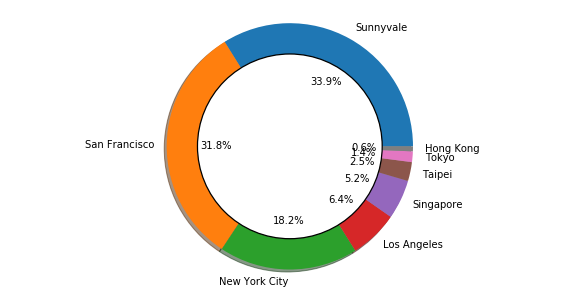

In [81]:
df = summer_df[summer_df.year == 2016]

# Now, let's initialize our plotting space in MatPlotLib.
fig, axs = plt.subplots(figsize=(10, 5))
location_counts = df.location.value_counts()
locations = location_counts.index

# Draw the circle
plt.pie(location_counts.values, labels=locations, autopct='%1.1f%%', shadow=True)
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')

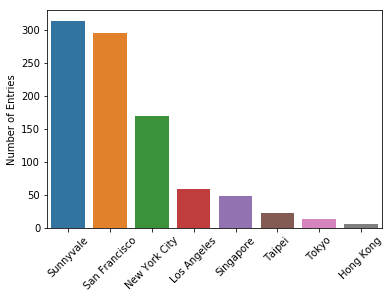

In [100]:
s_student_counts = df.location.value_counts()

plot = sns.barplot(x=s_student_counts.index, y=s_student_counts.values)

plot.set_xticklabels(s_student_counts.index, rotation=45)
plot.set_ylabel("Number of Entries")
display(plot)

In [101]:
calc_nps(summer_df[summer_df.location == "Sunnyvale"])

12.420382165605096